In [22]:
import torch
from torch import nn
import torch.functional as F
from tqdm import tqdm
from get_orlov_datasets import get_orlov_datasets
from autoencoder import Autoencoder, Encoder, Decoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [23]:
# PRETRAINED_AUTOENCODER_FILE = './checkpoints/autoencoder/old/ldim-2048_c_hid-32_lam-100-smaller-4/checkpoints/epoch=49-step=7500.ckpt'
SUBIMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_LOADERS_WORKERS = 0
EPOCHS_NUM = 1

In [56]:
train_loader, val_loader, test_loader, additional = get_orlov_datasets(num_loaders_workers=NUM_LOADERS_WORKERS,
                                                                        batch_size=BATCH_SIZE, subimage_size=SUBIMAGE_SIZE)

In [57]:
data_train, data_test, train_indices, val_indices, test_indices = additional
train_count, val_count, test_count = len(train_indices), len(val_indices), len(test_indices)

In [40]:
class Simplenet15(nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 7, padding='same')
        # self.batchnorm1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(20, 50, 5, padding='same')
        # self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(50, 120, 3, padding='same')
        # self.batchnorm3 = nn.BatchNorm2d(64)
        # self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(120 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 3)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = self.pool(self.tanh(self.conv3(x)))
        # x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.tanh(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
model = Simplenet15()
model = model.to(device)

In [29]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float("inf")
criterion = torch.nn.CrossEntropyLoss()
lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.33, patience=3)
version = '1.5-1'

In [30]:
def calc_val(best_val_loss):
    val_loss = 0
    images_count = 0
    val_acc = 0
    val_precision = 0
    val_recall = 0
    model.eval()    
    
    for images, class_idxs in tqdm(val_loader):
        with torch.no_grad():
            images = images.to(device)
            class_idxs = class_idxs.to(device)
            output = model(images)
            loss = criterion(output, class_idxs)              

            val_loss += loss.item() * images.size()[0]
            images_count += images.size()[0]

            output_labels = torch.argmax(output, dim=1).cpu().detach().numpy()
            class_idxs_np = class_idxs.cpu().numpy()

            batch_accuracy = accuracy_score(class_idxs_np, output_labels)
            batch_precision = precision_score(class_idxs_np, output_labels, average='macro', zero_division=0)
            batch_recall = recall_score(class_idxs_np, output_labels, average='macro', zero_division=0)

            val_acc += batch_accuracy * images.size()[0]
            val_precision += batch_precision * images.size()[0]
            val_recall += batch_recall * images.size()[0]

    val_loss = val_loss / images_count
    val_acc = val_acc / images_count
    val_precision = val_precision / images_count
    val_recall = val_recall / images_count
    
    scheduler.step(val_loss)

    print(f'Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}, precision: {val_precision:.4f}, recall: {val_recall:.4f}')
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"./checkpoints/classifier/simplenet_{version}.pt")
        print("Saved state dict!")
    return best_val_loss

In [31]:
batch_num = 0
eval_every = 50
for epoch in range(EPOCHS_NUM):
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_precision = 0.0
    epoch_recall = 0.0
    images_count = 0

    print(f'EPOCH {epoch + 1}')

    model.train()
    for images, class_idxs in train_loader:
        images = images.to(device)
        class_idxs = class_idxs.to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, class_idxs)

        loss.backward()
        optimizer.step()

        output_labels = torch.argmax(output, dim=1).cpu().detach().numpy()
        class_idxs_np = class_idxs.cpu().numpy()

        batch_accuracy = accuracy_score(class_idxs_np, output_labels)
        batch_precision = precision_score(class_idxs_np, output_labels, average='macro', zero_division=0)
        batch_recall = recall_score(class_idxs_np, output_labels, average='macro', zero_division=0)

        images_count += images.size()[0]
        epoch_acc += batch_accuracy * images.size()[0]
        epoch_precision += batch_precision * images.size()[0]
        epoch_recall += batch_recall * images.size()[0]

        epoch_loss += loss.item() * images.size()[0]

        if batch_num % eval_every == 0:
            train_losses.append(loss.item())
            train_accs.append(batch_accuracy)
            print(f"Batch {batch_num} training loss: {loss.item():.4f}, accuracy: {batch_accuracy:.4f}, precision: {batch_precision:.4f}, recall: {batch_recall:.4f}")
            best_val_loss = calc_val(best_val_loss)
        
        batch_num += 1

    epoch_loss = epoch_loss / images_count
    epoch_acc = epoch_acc / images_count
    epoch_precision = epoch_precision / images_count
    epoch_recall = epoch_recall / images_count

    print(f"Epoch training loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}, precision: {epoch_precision:.4f}, recall: {epoch_recall:.4f}")
    
    print()

EPOCH 1
Batch 0 training loss: 1.1096, accuracy: 0.3125, precision: 0.1042, recall: 0.3333


100%|██████████| 82/82 [01:05<00:00,  1.26it/s]


Validation loss: 1.0971, accuracy: 0.2927, precision: 0.0988, recall: 0.3313
Saved state dict!
Batch 50 training loss: 0.8185, accuracy: 0.6250, precision: 0.4667, recall: 0.4762


100%|██████████| 82/82 [01:15<00:00,  1.08it/s]


Validation loss: 0.9459, accuracy: 0.5869, precision: 0.4729, recall: 0.5014
Saved state dict!
Batch 100 training loss: 0.6892, accuracy: 0.7500, precision: 0.8258, recall: 0.7333


100%|██████████| 82/82 [01:08<00:00,  1.20it/s]


Validation loss: 0.9691, accuracy: 0.6006, precision: 0.4539, recall: 0.5888
Batch 150 training loss: 0.8222, accuracy: 0.5625, precision: 0.3651, recall: 0.5000


100%|██████████| 82/82 [01:07<00:00,  1.22it/s]


Validation loss: 1.2206, accuracy: 0.3133, precision: 0.1698, recall: 0.2293
Batch 200 training loss: 1.0081, accuracy: 0.3125, precision: 0.2929, recall: 0.5179


100%|██████████| 82/82 [01:07<00:00,  1.22it/s]


Validation loss: 1.2353, accuracy: 0.5008, precision: 0.3839, recall: 0.4039
Batch 250 training loss: 0.7253, accuracy: 0.5000, precision: 0.3598, recall: 0.6667


100%|██████████| 82/82 [01:10<00:00,  1.16it/s]


Validation loss: 1.1005, accuracy: 0.6242, precision: 0.4126, recall: 0.5843
Batch 300 training loss: 0.9462, accuracy: 0.6875, precision: 0.6722, recall: 0.6524


100%|██████████| 82/82 [01:08<00:00,  1.19it/s]


Validation loss: 1.2724, accuracy: 0.5602, precision: 0.4398, recall: 0.4846
Batch 350 training loss: 0.9262, accuracy: 0.6875, precision: 0.6889, recall: 0.7071


100%|██████████| 82/82 [01:11<00:00,  1.14it/s]


Validation loss: 1.4036, accuracy: 0.4184, precision: 0.4312, recall: 0.4066
Batch 400 training loss: 0.7485, accuracy: 0.6250, precision: 0.7333, recall: 0.6024


100%|██████████| 82/82 [01:04<00:00,  1.26it/s]


Validation loss: 1.3221, accuracy: 0.5389, precision: 0.4269, recall: 0.5188
Batch 450 training loss: 0.6163, accuracy: 0.6250, precision: 0.4444, recall: 0.6667


100%|██████████| 82/82 [01:10<00:00,  1.16it/s]


Validation loss: 1.5046, accuracy: 0.4451, precision: 0.4163, recall: 0.4318
Batch 500 training loss: 1.1188, accuracy: 0.5000, precision: 0.3386, recall: 0.6000


100%|██████████| 82/82 [01:12<00:00,  1.13it/s]


Validation loss: 1.3900, accuracy: 0.5130, precision: 0.4219, recall: 0.4850
Batch 550 training loss: 0.6743, accuracy: 0.6250, precision: 0.7315, recall: 0.6595


100%|██████████| 82/82 [01:11<00:00,  1.15it/s]


Validation loss: 1.3656, accuracy: 0.3712, precision: 0.3347, recall: 0.3274
Epoch training loss: 0.7114, accuracy: 0.6256, precision: 0.5728, recall: 0.6182



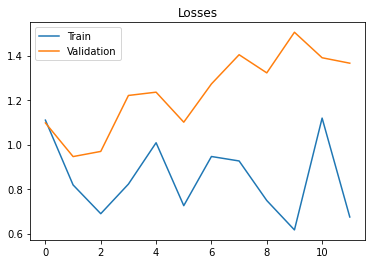

In [32]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Losses")
plt.legend()
plt.show()

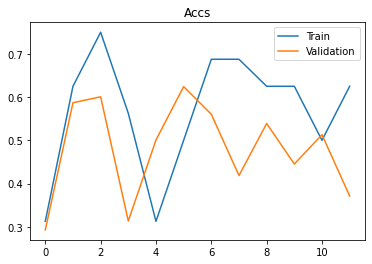

In [33]:
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.title("Accs")
plt.legend()
plt.show()

In [46]:
import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '../..'))


In [47]:
from production.backend.prediction.simplenet import SimpleNet

In [53]:
model = SimpleNet()
model = model.to(device)

In [54]:
model.load_state_dict(torch.load(f"./checkpoints/classifier/simplenet_1.5.pt",  map_location=device))

<All keys matched successfully>

In [58]:
test_loss = 0
images_count = 0
test_acc = 0
test_precision = 0
test_recall = 0
model.eval()    

for images, class_idxs in tqdm(test_loader):
    with torch.no_grad():
        images = images.to(device)
        class_idxs = class_idxs.to(device)
        output = model(images)
        loss = criterion(output, class_idxs)              

        test_loss += loss.item() * images.size()[0]
        images_count += images.size()[0]

        output_labels = torch.argmax(output, dim=1).cpu().detach().numpy()
        class_idxs_np = class_idxs.cpu().numpy()

        batch_accuracy = accuracy_score(class_idxs_np, output_labels)
        batch_precision = precision_score(class_idxs_np, output_labels, average='macro', zero_division=0)
        batch_recall = recall_score(class_idxs_np, output_labels, average='macro', zero_division=0)

        test_acc += batch_accuracy * images.size()[0]
        test_precision += batch_precision * images.size()[0]
        test_recall += batch_recall * images.size()[0]

test_loss = test_loss / images_count
test_acc = test_acc / images_count
test_precision = test_precision / images_count
test_recall = test_recall / images_count

print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}, precision: {test_precision:.4f}, recall: {test_recall:.4f}')

100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

Test loss: 0.8404, accuracy: 0.7879, precision: 0.8025, recall: 0.7648


In [59]:
_, _, test_loader_full, additional_full = get_orlov_datasets(num_loaders_workers=NUM_LOADERS_WORKERS,
                                        batch_size=BATCH_SIZE, subimage_size=None)

In [60]:
data_train, data_test_full, train_indices, val_indices, test_indices = additional_full
train_count, val_count, test_count = len(train_indices), len(val_indices), len(test_indices)

In [62]:
outputs = []
class_idxs = []

for test_id in test_indices:
    with torch.no_grad():
        batch_parts, class_idx, _ = data_test_full.get_image_subimages_batch(test_id)

        batch_parts = batch_parts.to(device)
        output = model(batch_parts)
        # output = torch.softmax(output, dim=1)
        output_image = torch.mean(output, dim=0)
        class_idx = torch.tensor(class_idx, device=device)
        class_idxs.append(class_idx.unsqueeze(0))
        outputs.append(output_image.unsqueeze(0))

outputs = torch.cat(outputs)
class_idxs = torch.cat(class_idxs)

loss = criterion(outputs, class_idxs)

class_idxs_np = class_idxs.cpu().numpy()
outputs_labels = torch.argmax(outputs, dim=1).cpu().detach().numpy()

accuracy = accuracy_score(class_idxs_np, outputs_labels)
precision = precision_score(class_idxs_np, outputs_labels, average='macro', zero_division=0)
recall = recall_score(class_idxs_np, outputs_labels, average='macro', zero_division=0)

print(f'loss: {loss:.4f}, accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')

loss: 0.7010, accuracy: 0.8182, precision: 0.8146, recall: 0.8182
